<a href="https://colab.research.google.com/github/Rashimanish/-Insurance-Cross-Selling/blob/main/Experiment/Model_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn keras

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# File path
file_path = '/content/drive/My Drive/INSURANCE/train.csv'
# Read dataset
df = pd.read_csv(file_path)


Mounted at /content/drive


## **Outlier Inspection & Treatment**

In [ ]:
# Outlier treatment function
def outlier_treatment(df):
    Q1 = df['Annual_Premium'].quantile(0.25)
    Q3 = df['Annual_Premium'].quantile(0.75)
    IQR = Q3 - Q1

    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR

    df['Annual_Premium'] = np.where(df['Annual_Premium'] > Upper_Whisker, Upper_Whisker,
                                    np.where(df['Annual_Premium'] < Lower_Whisker, Lower_Whisker,
                                             df['Annual_Premium']))
    return df


## **Feature Engineering**

In [ ]:
# Feature engineering function
def feature_engineering(df):

  #categorical --> numerical
    df["Vehicle_Age"] = df["Vehicle_Age"].astype('category').cat.rename_categories({
        "1-2 Year": 1,
        "< 1 Year": 0,
        "> 2 Years": 2
    }).astype('int8')

    #Binary Encoding
    df['Gender'] = (df['Gender'] == 'Male').astype(np.uint8)
    df['Vehicle_Damage'] = (df['Vehicle_Damage'] == 'Yes').astype(np.uint8)

    #data types conversion for memory efficiency
    df['Age'] = df['Age'].astype('int8')
    df['Driving_License'] = df['Driving_License'].astype('int8')
    df['Region_Code'] = df['Region_Code'].astype('int8')
    df['Previously_Insured'] = df['Previously_Insured'].astype('int8')
    df['Annual_Premium'] = df['Annual_Premium'].astype('int32')
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int16')
    df['Vintage'] = df['Vintage'].astype('int16')

    # Create new features
    df['Annual_Premium_Insurance'] = df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str)
    df['Annual_Premium_Insurance'] = pd.factorize(df['Annual_Premium_Insurance'])[0] + 1

    df['Vehicle_Age_Insurance'] = df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str)
    df['Vehicle_Age_Insurance'] = pd.factorize(df['Vehicle_Age_Insurance'])[0] + 1

    return df



## **Standard scalar is applied for models sensitive to the magnitude of features such as --> logistic regression , KNN**

In [ ]:
# Scaling function
def standard_scaling(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [ ]:
# sampling
def sampling(X, y, seed):
    # Random subsampling
    sample_size = len(y[y == 1])  # minority
    X_random = X.sample(n=sample_size * 2, random_state=seed)
    y_random = y.loc[X_random.index]

    # Separate majority and minority classes
    X_maj = X_random[y_random == 0]
    y_maj = y_random[y_random == 0]
    X_min = X_random[y_random == 1]
    y_min = y_random[y_random == 1]

    X_maj = X_maj.drop_duplicates()
    y_maj = y_maj.loc[X_maj.index]

    # sample size = the minority class
    size = len(y_min)

    # Undersampling
    X_maj_undersampled, y_maj_undersampled = resample(X_maj, y_maj,
                                                       replace=False,
                                                       n_samples=size,
                                                       random_state=seed)

    # Combine undersampled majority class with minority class
    X_combined = pd.concat([X_maj_undersampled, X_min])
    y_combined = pd.concat([y_maj_undersampled, y_min])

    return X_combined, y_combined

In [ ]:
X = df.drop(columns=['id', 'Response'])
y = df['Response']

# Call OT
X = outlier_treatment(X)

In [ ]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,21,1,35.0,0,1-2 Year,Yes,60712.0,124.0,187
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254
3,Female,35,1,1.0,0,1-2 Year,Yes,4016.0,156.0,76
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294


In [ ]:
X = feature_engineering(X)

In [ ]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Insurance,Vehicle_Age_Insurance
0,1,21,1,35,0,1,1,60712,124,187,1,1
1,1,43,1,28,0,2,1,58911,26,288,2,2
2,0,25,1,14,1,0,0,38043,152,254,3,3
3,0,35,1,1,0,1,1,4016,156,76,4,1
4,0,36,1,15,1,1,0,31951,152,294,5,4


In [ ]:
#for logistic reg
#X = standard_scaling(X)

In [ ]:
# Perform Sampling
X_combined, y_combined = sampling(X, y, seed=35)

In [ ]:
# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=35)

def evaluate_model(model, X, y):
    metrics_list = []
    fpr_list = []
    tpr_list = []
    roc_auc_list = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if isinstance(model, (LogisticRegression, KNeighborsClassifier, MLPClassifier)):
          X_train, X_test = standard_scaling(X_train, X_test)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        # Calculate AUC
        roc_auc = auc(fpr, tpr)

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'roc_auc': roc_auc,
            'conf_matrix': confusion_matrix(y_test, y_pred)
        }
        metrics_list.append(metrics)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(roc_auc)

    # Average scalar metrics
    avg_metrics = {
        'accuracy': np.mean([m['accuracy'] for m in metrics_list]),
        'precision': np.mean([m['precision'] for m in metrics_list]),
        'recall': np.mean([m['recall'] for m in metrics_list]),
        'f1_score': np.mean([m['f1_score'] for m in metrics_list]),
        'roc_auc': np.mean(roc_auc_list),
        'conf_matrix': np.sum([m['conf_matrix'] for m in metrics_list], axis=0)
    }

    # Average ROC curve values
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    mean_tpr[0] = 0.0  # Ensure the curve starts at (0,0)
    mean_auc = np.mean(roc_auc_list)

    return avg_metrics, mean_fpr, mean_tpr, mean_auc

In [ ]:
def performance_metrics(model_name, metrics):
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
        'Score': [
            metrics['accuracy'],
            metrics['precision'],
            metrics['recall'],
            metrics['f1_score'],
            metrics['roc_auc']
        ]
    })

    print(f"\n{model_name} Model Performance Metrics")
    display(metrics_df)

    # Confusion matrix
    conf_matrix_df = pd.DataFrame(metrics['conf_matrix'],
                                  index=['Actual Negative', 'Actual Positive'],
                                  columns=['Predicted Negative', 'Predicted Positive'])

    print("\nConfusion Matrix:")
    display(conf_matrix_df)

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## **Logistic Regression**

In [ ]:
logreg_model = LogisticRegression(random_state=35)

In [ ]:
print(X_combined.isnull().sum())

Gender                      0
Age                         0
Driving_License             0
Region_Code                 0
Previously_Insured          0
Vehicle_Age                 0
Vehicle_Damage              0
Annual_Premium              0
Policy_Sales_Channel        0
Vintage                     0
Annual_Premium_Insurance    0
Vehicle_Age_Insurance       0
dtype: int64


In [ ]:
#Logistic Regression Evaluation
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(logreg_model, X_combined, y_combined)
performance_metrics("Logistic Regression", avg_metrics)


Logistic Regression Model Performance Metrics


,Metric,Score
0,Accuracy,0.779233
1,Precision,0.718801
2,Recall,0.917333
3,F1 Score,0.806021
4,ROC AUC,0.839424



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,223035,124841
Actual Positive,28758,319118


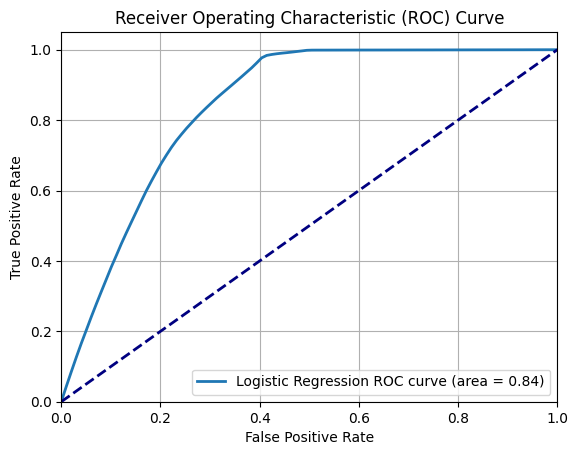

In [ ]:
# Plot ROC curve
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Logistic Regression")

## **Tuned Logistic Regression Model**

In [ ]:
# Print available parameters
print("Available parameters for Logistic Regression:")
for param, value in logreg_model.get_params().items():
    print(f"{param}: {value}")

Available parameters for Logistic Regression:
C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 1000
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False


In [ ]:
# Define parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}

# Initialize GridSearchCV
grid_search_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_logreg,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=35),
    scoring='roc_auc',
    n_jobs=-1
)

# Perform Grid Search
grid_search_logreg.fit(X_combined, y_combined)

# Tuned Model and Parameters
tuned_logreg_model = grid_search_logreg.best_estimator_
best_params_logreg = grid_search_logreg.best_params_

print(f"Best Logistic Regression Parameters: {best_params_logreg}")

Best Logistic Regression Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
# Evaluate Tuned Logistic Regression
avg_metrics_tuned_logreg, avg_fpr_tuned_logreg, avg_tpr_tuned_logreg, avg_roc_auc_tuned_logreg = evaluate_model(tuned_logreg_model, X_combined, y_combined)
performance_metrics("Tuned Logistic Regression Model", avg_metrics_tuned_logreg)


Tuned Logistic Regression Model Model Performance Metrics


,Metric,Score
0,Accuracy,0.785537
1,Precision,0.707451
2,Recall,0.973741
3,F1 Score,0.819507
4,ROC AUC,0.841025



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,207798,140078
Actual Positive,9135,338741


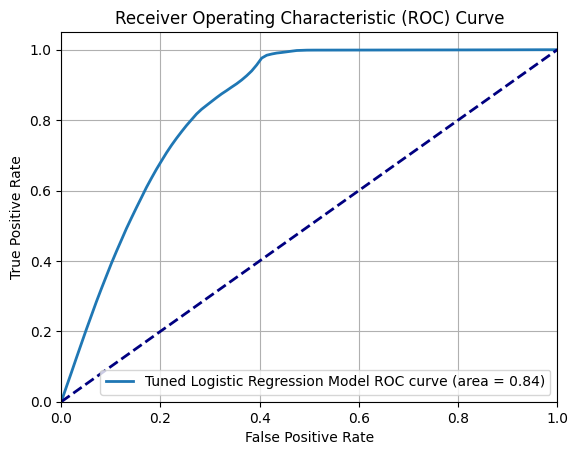

In [ ]:
plot_roc_curve(avg_fpr_tuned_logreg, avg_tpr_tuned_logreg, avg_roc_auc_tuned_logreg, "Tuned Logistic Regression Model")

## **XGBoost Model**

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=35)

In [ ]:
# Evaluating XGBoost
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(xgb_model, X_combined, y_combined)
performance_metrics("XGBoost", avg_metrics)


XGBoost Model Performance Metrics


,Metric,Score
0,Accuracy,0.811049
1,Precision,0.752905
2,Recall,0.926002
3,F1 Score,0.830530
4,ROC AUC,0.876469



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,242737,105975
Actual Positive,25804,322908


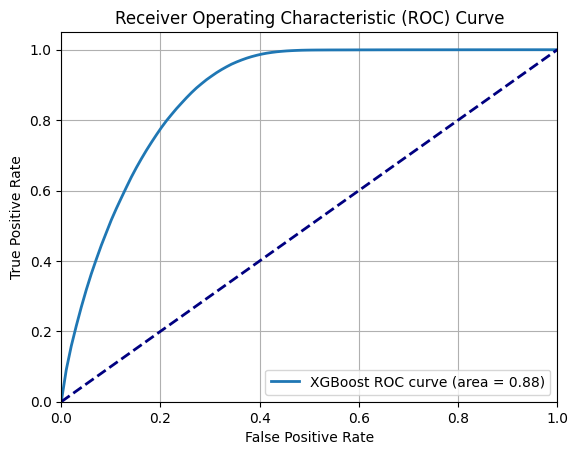

In [ ]:
# Plot ROC curve
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "XGBoost")

## **Tuned XGBoost**

In [ ]:
#available parameters
print("Available parameters for XGBClassifier:")
for param, value in xgb_model.get_params().items():
    print(f"{param}: {value}")

Available parameters for XGBClassifier:
objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: None
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: None
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: None
n_jobs: None
num_parallel_tree: None
random_state: 35
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: None


In [ ]:
# Sample 10% of the data
X_sample, _, y_sample, _ = train_test_split(X_combined, y_combined, test_size=0.95, random_state=42, stratify=y_combined)

# parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb.XGBClassifier(random_state=42, tree_method='hist'),
    param_grid_xgb,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=35),
    scoring='roc_auc',
    n_jobs=1
)

grid_search_xgb.fit(X_sample, y_sample)

# Best Model and Parameters
tuned_xgb_model = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

print(f"Best XGBoost Parameters: {best_params_xgb}")

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1}


In [ ]:
# Evaluate Tuned XGBoost
avg_metrics_tuned_xgb, avg_fpr_tuned_xgb, avg_tpr_tuned_xgb, avg_roc_auc_tuned_xgb = evaluate_model(tuned_xgb_model, X_combined, y_combined)
performance_metrics("Tuned XGBoost", avg_metrics_tuned_xgb)


Tuned XGBoost Model Performance Metrics


,Metric,Score
0,Accuracy,0.807426
1,Precision,0.745926
2,Recall,0.932463
3,F1 Score,0.828829
4,ROC AUC,0.870718



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,237957,110755
Actual Positive,23551,325161


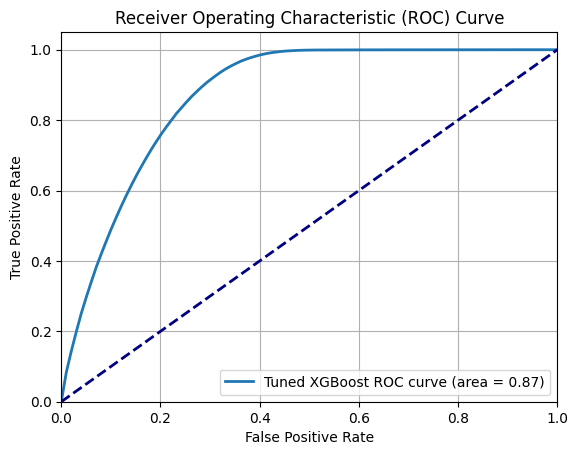

In [ ]:
plot_roc_curve(avg_fpr_tuned_xgb, avg_tpr_tuned_xgb, avg_roc_auc_tuned_xgb, "Tuned XGBoost")

## **Gaussian Naive Bayes**

In [ ]:
gnb_model = GaussianNB()

# Evaluate Gaussian Naive Bayes
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(gnb_model, X_combined, y_combined)
performance_metrics("Gaussian Naive Bayes", avg_metrics)


Gaussian Naive Bayes Model Performance Metrics


,Metric,Score
0,Accuracy,0.763641
1,Precision,0.724381
2,Recall,0.851128
3,F1 Score,0.782656
4,ROC AUC,0.821957



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,235218,112658
Actual Positive,51789,296087


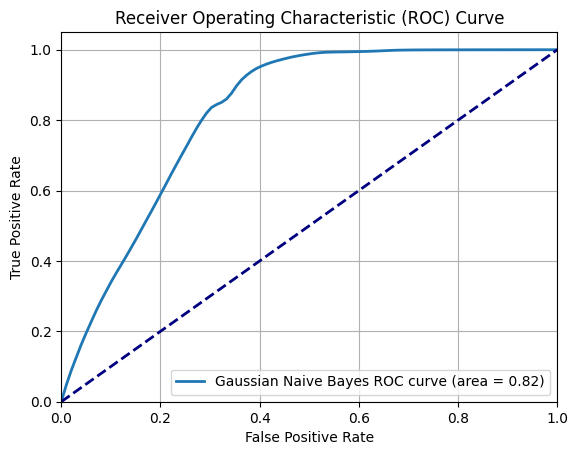

In [ ]:
# Plot ROC curve
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Gaussian Naive Bayes")

## **Random Forest Classifier**

In [ ]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=35)
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(rf_model, X_combined, y_combined)
performance_metrics("Random Forest", avg_metrics)


Random Forest Model Performance Metrics


,Metric,Score
0,Accuracy,0.794581
1,Precision,0.746770
2,Recall,0.891461
3,F1 Score,0.812724
4,ROC AUC,0.853466



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,243297,105415
Actual Positive,37849,310863


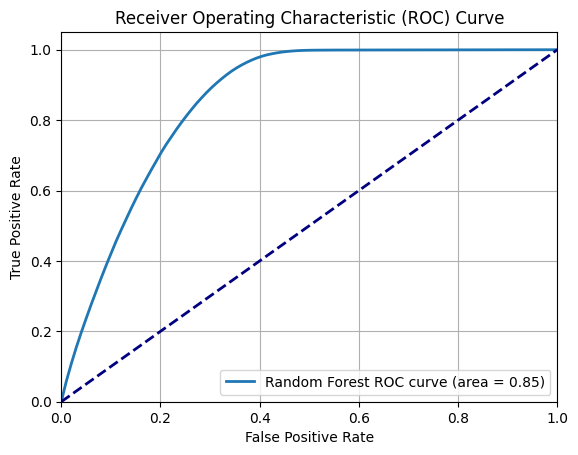

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Random Forest")

### **Tuned Random Forest**

In [ ]:
# Sample 10% of the data
X_sample, _, y_sample, _ = train_test_split(X_combined, y_combined, test_size=0.95, random_state=42, stratify=y_combined)

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=35),
    param_grid_rf,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=35),
    scoring='roc_auc',
    n_jobs=1
)

# Perform Grid Search on the sampled data
grid_search_rf.fit(X_sample, y_sample)

# Tuned Model and Parameters
tuned_rf_model = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

print(f"Best Random Forest Parameters: {best_params_rf}")

Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}



Tuned Random Forest Model Model Performance Metrics


,Metric,Score
0,Accuracy,0.804883
1,Precision,0.743811
2,Recall,0.930134
3,F1 Score,0.826602
4,ROC AUC,0.865544



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,236996,111716
Actual Positive,24363,324349


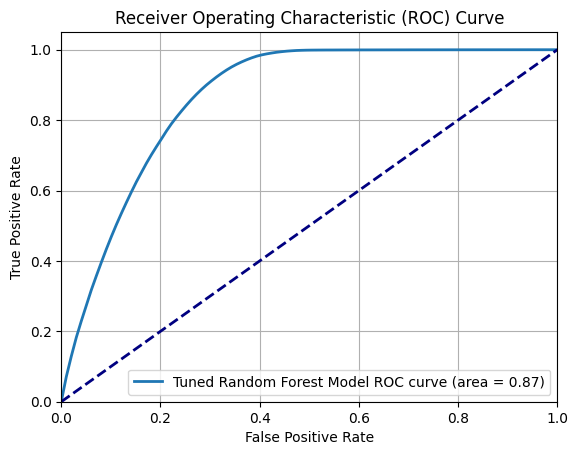

In [ ]:
# Evaluate Tuned Random Forest
avg_metrics_tuned_rf, avg_fpr_tuned_rf, avg_tpr_tuned_rf, avg_roc_auc_tuned_rf = evaluate_model(tuned_rf_model, X_combined, y_combined)
performance_metrics("Tuned Random Forest Model", avg_metrics_tuned_rf)
plot_roc_curve(avg_fpr_tuned_rf, avg_tpr_tuned_rf, avg_roc_auc_tuned_rf, "Tuned Random Forest Model")

## **Decision Tree**

In [ ]:
dt_model = DecisionTreeClassifier(random_state=35)
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(dt_model, X_combined, y_combined)
performance_metrics("Decision Tree", avg_metrics)

avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(logreg_model, X_combined, y_combined)
performance_metrics("Logistic Regression", avg_metrics)


Decision Tree Model Performance Metrics


,Metric,Score
0,Accuracy,0.726191
1,Precision,0.729904
2,Recall,0.718120
3,F1 Score,0.723963
4,ROC AUC,0.726329



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,256046,92666
Actual Positive,98295,250417


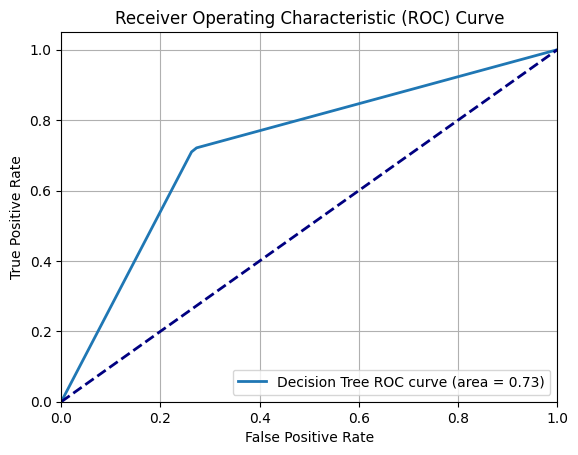

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Decision Tree")

## **LightGBM**

In [ ]:
lgb_model = lgb.LGBMClassifier()
avg_metrics_lgb, avg_fpr_lgb, avg_tpr_lgb, avg_roc_auc_lgb = evaluate_model(lgb_model, X_combined, y_combined)
performance_metrics("LightGBM", avg_metrics_lgb)

[LightGBM] [Info] Number of positive: 232475, number of negative: 232474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 464949, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000004
[LightGBM] [Info] Start training from score 0.000004
[LightGBM] [Info] Number of positive: 232474, number of negative: 232475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 464949, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000004
[LightGBM] [Info] Start training from score -0.000004
[LightGBM]

,Metric,Score
0,Accuracy,0.809946
1,Precision,0.749235
2,Recall,0.931743
3,F1 Score,0.830581
4,ROC AUC,0.874655



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,239966,108746
Actual Positive,23802,324910


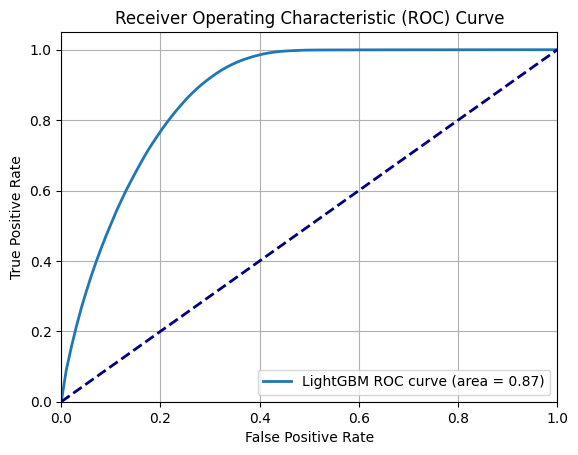

In [ ]:
plot_roc_curve(avg_fpr_lgb, avg_tpr_lgb, avg_roc_auc_lgb, "LightGBM")

## **Tuned LightGBM**

In [ ]:
# Print available parameters for LGBMClassifier
print("Available parameters for LGBMClassifier:")
for param, value in lgb.LGBMClassifier().get_params().items():
    print(f"{param}: {value}")

Available parameters for LGBMClassifier:
boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.1
max_depth: -1
min_child_samples: 20
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 100
n_jobs: None
num_leaves: 31
objective: None
random_state: None
reg_alpha: 0.0
reg_lambda: 0.0
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0


In [ ]:
# Sample 10% of the data
X_sample, _, y_sample, _ = train_test_split(X_combined, y_combined, test_size=0.95, random_state=42, stratify=y_combined)

param_grid_lgb = {
    'max_depth': [6, 9],
    'n_estimators': [100, 500],
    'num_leaves': [50, 100]
}

# Initialize GridSearchCV for LightGBM
grid_search_lgb = GridSearchCV(
    lgb.LGBMClassifier(random_state=42),
    param_grid_lgb,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=35),
    scoring='roc_auc',
    n_jobs=1
)

# Fit GridSearchCV
grid_search_lgb.fit(X_sample, y_sample)

# Best Model and Parameters
tuned_lgb_model = grid_search_lgb.best_estimator_
best_params_lgb = grid_search_lgb.best_params_

print(f"Best LightGBM Parameters: {best_params_lgb}")

[LightGBM] [Info] Number of positive: 11624, number of negative: 11623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 23247, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000086
[LightGBM] [Info] Start training from score 0.000086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
# Evaluate the Tuned LightGBM Model
avg_metrics_tuned_lgb, avg_fpr_tuned_lgb, avg_tpr_tuned_lgb, avg_roc_auc_tuned_lgb = evaluate_model(tuned_lgb_model, X_combined, y_combined)
performance_metrics("Tuned LightGBM", avg_metrics_tuned_lgb)

[LightGBM] [Info] Number of positive: 232475, number of negative: 232474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 464949, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000004
[LightGBM] [Info] Start training from score 0.000004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,Metric,Score
0,Accuracy,0.808854
1,Precision,0.747586
2,Recall,0.932586
3,F1 Score,0.829901
4,ROC AUC,0.872598



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,238910,109802
Actual Positive,23508,325204


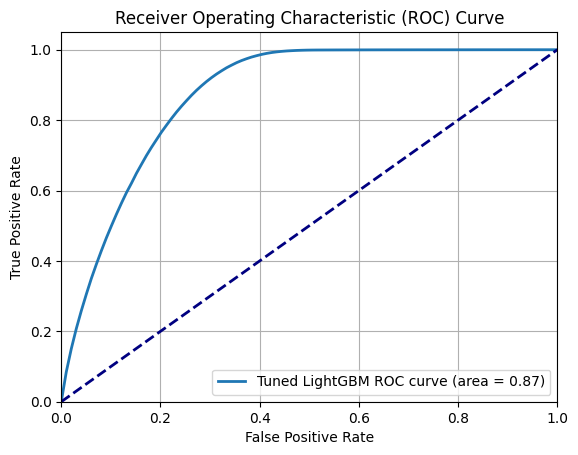

In [ ]:
plot_roc_curve(avg_fpr_tuned_lgb, avg_tpr_tuned_lgb, avg_roc_auc_tuned_lgb, "Tuned LightGBM")

## **K-Nearest Neighbors**

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(knn_model, X_combined, y_combined)
performance_metrics("K-Nearest Neighbors", avg_metrics)


K-Nearest Neighbors Model Performance Metrics


,Metric,Score
0,Accuracy,0.771589
1,Precision,0.737862
2,Recall,0.842489
3,F1 Score,0.786712
4,ROC AUC,0.825734



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,244339,104373
Actual Positive,54926,293786


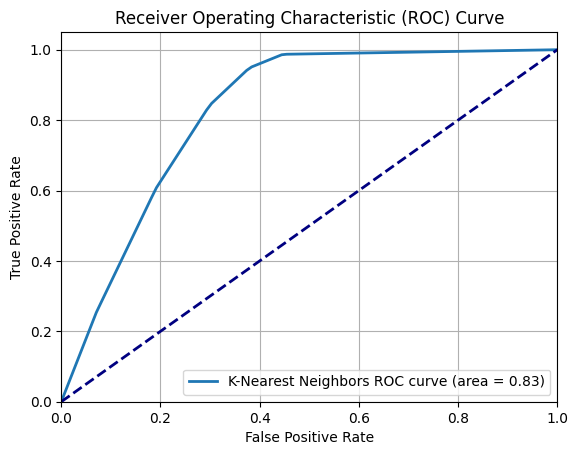

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "K-Nearest Neighbors")

## **Tuning KNN**





In [ ]:
# Print available parameters
print("Available parameters for KNeighborsClassifier:")
for param, value in KNeighborsClassifier().get_params().items():
    print(f"{param}: {value}")

Available parameters for KNeighborsClassifier:
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform


In [ ]:
#parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# GridSearchCV
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=35),
    scoring='roc_auc',
    n_jobs=1
)

grid_search_knn.fit(X_combined, y_combined)

# Best Model and Parameters
tuned_knn_model = grid_search_knn.best_estimator_
best_params_knn = grid_search_knn.best_params_

print(f"Best KNN Parameters: {best_params_knn}")

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [ ]:
# Evaluate Tuned KNN
avg_metrics_tuned_knn, avg_fpr_tuned_knn, avg_tpr_tuned_knn, avg_roc_auc_tuned_knn = evaluate_model(tuned_knn_model, X_combined, y_combined)
performance_metrics("Tuned KNN Model", avg_metrics_tuned_knn)


Tuned KNN Model Model Performance Metrics


,Metric,Score
0,Accuracy,0.777058
1,Precision,0.739396
2,Recall,0.855720
3,F1 Score,0.793316
4,ROC AUC,0.833466



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,243539,105173
Actual Positive,50312,298400


In [ ]:
# Plot ROC curve
plot_roc_curve(avg_fpr_tuned_knn, avg_tpr_tuned_knn, avg_roc_auc_tuned_knn, "Tuned KNN Model")

# **Neural Network**

In [ ]:
# MLP model
mlp_model = MLPClassifier(random_state=35)
avg_metrics, mean_fpr, mean_tpr, mean_auc = evaluate_model(mlp_model, X_combined, y_combined)

# Display performance metrics and plot ROC curve
performance_metrics("MLP Classifier", avg_metrics)


MLP Classifier Model Performance Metrics


,Metric,Score
0,Accuracy,0.801310
1,Precision,0.742706
2,Recall,0.922199
3,F1 Score,0.822722
4,ROC AUC,0.859346



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,237271,111441
Actual Positive,27130,321582


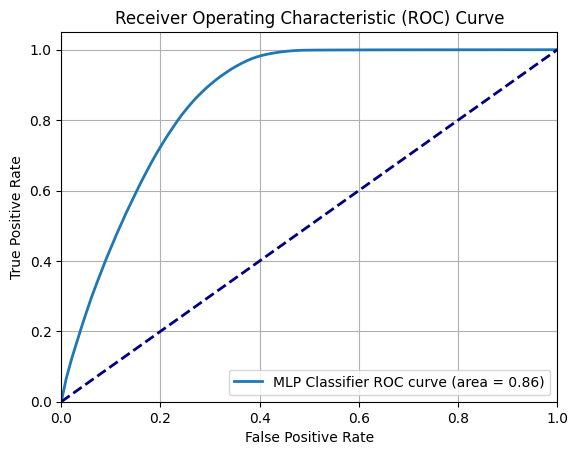

In [ ]:
plot_roc_curve(mean_fpr, mean_tpr, mean_auc, "MLP Classifier")

## **MLP Tuning**

In [ ]:
# Sample 10% of the data
X_sample, _, y_sample, _ = train_test_split(X_combined, y_combined, test_size=0.95, random_state=42, stratify=y_combined)

# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

#GridSearchCV
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=1, verbose=2)

#Grid Search
grid_search.fit(X_sample, y_sample)

# best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=sgd; total time=   3.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam; total time=   2.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam; total time=   2.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=constant, solver=adam; total time=   5.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(10, 30, 10), learning_rate=adaptive, solver=sgd; total time=  12.2s
[CV] END activation=tanh, alpha=0.0001, 

In [ ]:
# Evaluate the best model
tuned_mlp_model = grid_search.best_estimator_
avg_metrics, mean_fpr, mean_tpr, mean_auc = evaluate_model(tuned_mlp_model, X_combined, y_combined)

In [ ]:
# Display performance metrics and plot ROC curve
performance_metrics("Tuned MLP Classifier", avg_metrics)


Tuned MLP Classifier Model Performance Metrics


,Metric,Score
0,Accuracy,0.800810
1,Precision,0.742657
2,Recall,0.920642
3,F1 Score,0.822124
4,ROC AUC,0.857382



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,237465,111247
Actual Positive,27673,321039


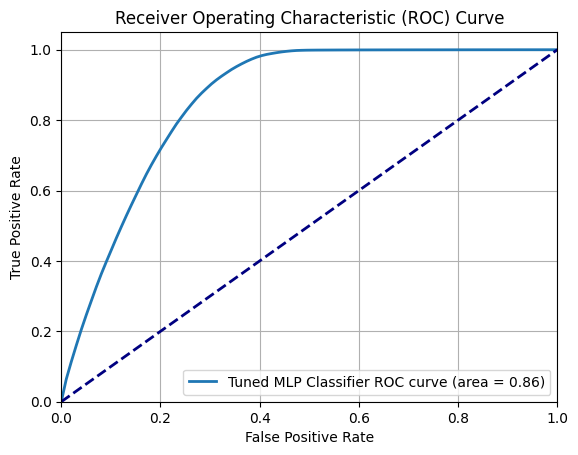

In [ ]:
plot_roc_curve(mean_fpr, mean_tpr, mean_auc, "Tuned MLP Classifier")

## **Meta Model**

In [ ]:
best_params_xgb = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 1
}

best_params_mlp = {
    'hidden_layer_sizes': (100, 50),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.0001,
    'learning_rate': 'adaptive',
}

# Define the base models
xgb_mod = XGBClassifier(
    **best_params_xgb,
    random_state=35,
    tree_method='hist'
)

mlp_mod = MLPClassifier(
    **best_params_mlp,
    random_state=35
)

# Define the Voting Classifier with soft voting
voting_model = VotingClassifier(
    estimators=[('xgb', xgb_mod), ('mlp', mlp_mod)],
    voting='soft',  # Soft voting uses predicted probabilities
    n_jobs=1  # Use all available cores to speed up training
)

In [ ]:
# Evaluate the Voting Classifier
avg_metrics, avg_fpr, avg_tpr, avg_roc_auc = evaluate_model(voting_model, X_combined, y_combined)
performance_metrics("Voting Classifier (Soft)", avg_metrics)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



Voting Classifier (Soft) Model Performance Metrics


,Metric,Score
0,Accuracy,0.803429
1,Precision,0.735893
2,Recall,0.947226
3,F1 Score,0.828142
4,ROC AUC,0.865321



Confusion Matrix:


,Predicted Negative,Predicted Positive
Actual Negative,230022,118690
Actual Positive,18403,330309


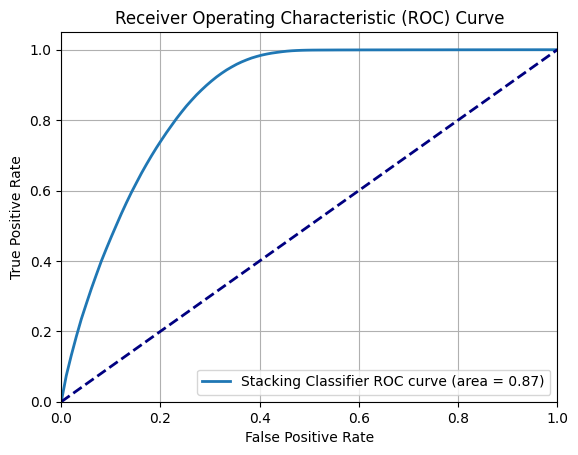

In [ ]:
plot_roc_curve(avg_fpr, avg_tpr, avg_roc_auc, "Stacking Classifier")

## **Testing on Kaggle Test Data**

In [ ]:
# Kaggle Test data
test_file_path = '/content/drive/My Drive/INSURANCE/test.csv'
test_df = pd.read_csv(test_file_path)

In [ ]:
X_test= test_df.drop(columns=['id'])

In [ ]:
X_test = outlier_treatment(X_test)
X_test = feature_engineering(X_test)

In [ ]:
X_test = standard_scaling(X, X_test)[1]

In [ ]:
X_test.shape

(7669866, 12)

In [ ]:
# Predict the test data
y_test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = logreg_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = tuned_logreg_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = gnb_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = tuned_rf_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = dt_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = tuned_lgb_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = mlp_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = tuned_mlp_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = tuned_xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred_proba = voting_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'Response': y_test_pred_proba
})

# Save CSV
submission_file_path = '/content/drive/My Drive/INSURANCE/submission.csv'
submission.to_csv(submission_file_path, index=False)


In [ ]:
submission.head(10)

,id,Response
0,11504798,0.568248
1,11504799,0.766454
2,11504800,0.822788
3,11504801,0.012323
4,11504802,0.323022
5,11504803,0.019971
6,11504804,0.865837
7,11504805,0.251050
8,11504806,0.007695
9,11504807,0.027492


In [ ]:
print("Sample predicted probabilities:", y_test_pred_proba[:10])

Sample predicted probabilities: [0.56824846 0.76645379 0.8227882  0.01232313 0.32302202 0.01997148
 0.86583731 0.25104974 0.0076953  0.02749153]
